# Modelo de recomendación

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [94]:
df = pd.read_csv('/kaggle/input/spotify-dataset/df_songs.csv')

In [95]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_genre,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,0.617978,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,pop,0.559504,0.839056,0.665871,True,0.056664,0.097127,0.000000,0.063256,0.518,0.477903,0.240945,0.953133
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,0.629213,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),pop,0.527076,0.664225,0.507233,True,0.036621,0.069899,0.004201,0.305276,0.693,0.334085,0.182352,0.953133
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,0.662921,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),pop,0.455625,0.866761,0.608407,False,0.071576,0.076405,0.000023,0.104360,0.613,0.490757,0.208316,0.953133
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,0.550562,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,pop,0.515524,0.864900,0.584556,True,0.097127,0.028296,0.000009,0.185649,0.277,0.477382,0.194464,0.953133
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,0.651685,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),pop,0.422500,0.693889,0.525833,True,0.035271,0.077239,0.000000,0.080012,0.725,0.490549,0.230801,0.953133


In [96]:
df.describe()

,track_popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
count,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000
mean,0.411510,0.451754,0.513626,0.421495,0.098426,0.152717,0.065676,0.165481,0.509312,0.469421,0.285104,0.720546
std,0.197534,0.181832,0.236740,0.141470,0.085541,0.171373,0.167241,0.115768,0.232680,0.173978,0.094592,0.291073
min,0.000000,0.005944,0.000139,0.000000,0.022153,0.000001,0.000000,0.009316,0.000010,0.000000,0.000000,0.000000
25%,0.269663,0.318096,0.328329,0.329304,0.040086,0.015972,0.000000,0.088652,0.329000,0.334020,0.224866,0.562326
50%,0.415730,0.452929,0.512656,0.431469,0.060530,0.082317,0.000016,0.118672,0.510000,0.477115,0.274422,0.863838
75%,0.561798,0.580644,0.698896,0.522671,0.124869,0.240590,0.004798,0.217528,0.691000,0.558260,0.335173,0.953133
max,1.000000,0.966289,1.000000,1.000000,0.651283,0.689139,0.690143,0.691145,0.991000,1.000000,0.693147,1.000000


# Entrenamiento de embeddings

Se decidió descartar el feature `mode` ya que, al ser incluida en el dataset, las predicciones siempre coinciden con el modo original (Mayor o menor).

Pero los oyentes no escuchan exclusivamente música de un modo, sino que consumen ambos modos de forma indistinta.

In [97]:
# Eliminación de "mode"
df.drop(columns=['mode'],inplace=True)

Se filtran los datos no numéricos para el entrenamiento del modelo de embeddings.

In [ ]:
# Selección de features para entrenamiento
features = ['track_popularity', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'year']

# Conversión de formato de las features
X = df[features].values.astype('float32')

In [ ]:
# División del dataset en test/train
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

Se crea un modelo no supevisado del tipo **Autoencoder denso** (Fully connected Autoencoder) que aprenda las representaciones comprimidas (embeddings).

In [ ]:
# Arquitectura Autoencoder 
model = Sequential([
    Input(shape=(len(features),)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu', name="embedding_layer"), # Embedding layer
    Dense(16, activation='relu'),
    Dense(len(features), activation='linear') # Output layer for reconstruction
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Configurar el EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Métrica a monitorear
    patience=20,                # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)

In [ ]:
# Entrenamiento del modelo y guardar el historial
with tf.device('/GPU:0'):  # GPU 0 es la primera GPU disponible
    history = model.fit(
        X_train, X_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, X_test),
        callbacks=[early_stopping]
    )

Epoch 1/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0445 - val_loss: 0.0057
Epoch 2/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - val_loss: 0.0034
Epoch 3/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - val_loss: 0.0027
Epoch 4/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - val_loss: 0.0026
Epoch 5/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 6/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 7/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 8/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 9/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 10/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 11/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 12/50
505/505 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Puede verse que el entrenamiento del modelo autoencoder es extremadamente rápido (~17seg en GPU hasta la epoch 5), lo que nos permitiría realizar el reentrenamiento del modelo en producción con los datos almacenados de las consultas realizadas por los usuarios.

De este modo pordíamos realizar la predicción en bache, alimentando el modelo con nuevos datos de interés para nuestro público target.

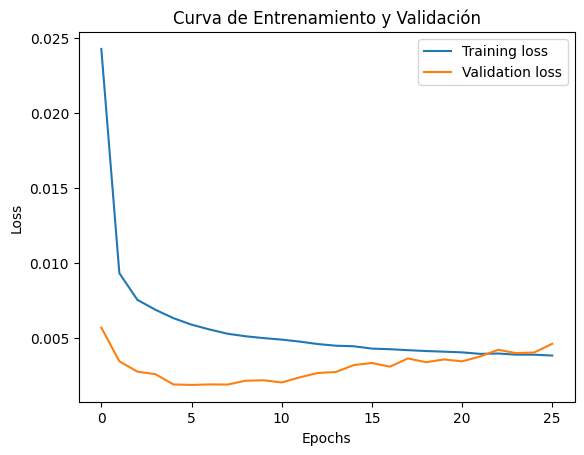

In [ ]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Curva de Entrenamiento y Validación')
plt.show()

Se extrae la capa de embeddings que nos permitirá comparar las canciones entre si dentro del espacio latente.

Nuestro vector de embeddings es de **32 dimensiones**, mientras que la dimensión de entrada son los **12 features** del dataframe. Es decir, un incremento de la dimensionalidad de 2,66x.

Gracias al autoencoder se consigue representar la información relacional entre las _features musicales_. Esto ocurre porque el modelo está diseñado para aprender representaciones compactas que capturen las relaciones relevantes entre las características.

In [ ]:
# Arquitectura del modelo de embeddings
input_layer = Input(shape=(len(features),))
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
embedding_layer = Dense(32, activation='relu', name="embedding_layer")(x)  # Capa de embedding
output_layer = Dense(len(features), activation='linear')(embedding_layer)

# Compilación del modelo
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Se inicializa el modelo ejecutando una entrada de muestra
sample_input = np.random.rand(1, len(features))  # Entrada aleatoria
_ = model.predict(sample_input)  # Inicializar el modelo ejecutando la predicción

# Extrae la capa de embedding
embedding_model = Model(inputs=model.input, outputs=model.get_layer("embedding_layer").output)
song_embeddings = embedding_model.predict(X)

print("Capa de Embeddings:", song_embeddings.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Capa de Embeddings: (23081, 32)


In [ ]:
# Exportación del modelo entrenado
embedding_model.save("/kaggle/working/songs_embeddings.h5")

# Búsqueda de simlitud en espacio latente

## Búsqueda de canciones _(para testing)_

Dentro del ML pipeline este proceso lo realizará el usuario seleccionando una canción a través de la UI web.

### Búsqueda por género

In [ ]:
# Índices para facilitar la búsqueda por género
genres = ['pop', # 0
          'rock', # 1
          'rap', # 2
          'r&b', # 3
          'edm', # 4
          'latin'] # 5

df[df['playlist_genre'] == genres[1]]  # Selecciona sólo un género
#df[df['playlist_genre'] != genres[1]]  # Todos los demás géneros

### Búsqueda por artista/canción

In [ ]:
# Búsqueda por artista/nombre
df.loc[df['track_name'] == 'Yesterday']

### Búsqueda por ID

Ejemplos para testing:
- **Reggaeton:** 3gu0fRSgFuc4FmrtIv0DnC
- **Pop:** 0r7CVbZTWZgbTCYdfa2P31
- **Rap:** 5yY9lUy8nbvjM1Uyo1Uqoc
- **Latin:** 1VgQ6AZ8tVV0uhvhH9usuj

In [83]:
# Búsqueda por ID
id_ = "5CMjjywI0eZMixPeqNd75R"
name = df.loc[df['track_id'] == id_]
song_index = df[df['track_id'] == id_].index.item()
print(name.iloc[0]['track_name'], 'by', name.iloc[0]['track_artist'], 'on album', name.iloc[0]['track_album_name'])
print()
df.iloc[song_index]

Lose Yourself to Dance by Daft Punk on album Random Access Memories



track_id            5CMjjywI0eZMixPeqNd75R
track_name          Lose Yourself to Dance
track_artist                     Daft Punk
track_popularity                  0.674157
track_album_id      4m2880jivSbbyEGAKfITCa
track_album_name    Random Access Memories
playlist_genre                         pop
danceability                      0.692224
energy                            0.434281
loudness                          0.350094
speechiness                       0.055435
acousticness                      0.080566
instrumentalness                  0.001139
liveness                            0.0726
valence                              0.674
tempo                              0.33533
duration_ms                       0.489098
year                              0.702332
Name: 559, dtype: object

## Generación de recomendaciones

Para la canción solicitada (user input) se generan 5 recomendaciones por búsqueda de similitud de coseno comparando el vector multidimensional de cada canción dentro del espacio latente (capa embeddings).

In [84]:
num_pred = 5 # Modificar a gusto para obtener más predicciones
similarities = cosine_similarity([song_embeddings[song_index]], song_embeddings)[0]

# Get top n most similar songs (excluding itself)
similar_indices = np.argsort(similarities)[-(num_pred+1):-1][::-1]
similar_songs = df.iloc[similar_indices]

for i, song in enumerate(similar_songs.index):
    print(f"""{i+1}º) "{similar_songs.loc[song, 'track_name']}" by {similar_songs.loc[song, 'track_artist']} on album "{similar_songs.loc[song, 'track_album_name']}" ({similar_songs.loc[song, 'playlist_genre'].title()})\n""")

1º) "Get Lucky" by Daft Punk on album "Random Access Memories" (Pop)

2º) "Porque Me Tratas Así?" by Wisin & Yandel on album "Wisin Vs Yandel "Los Extraterrestres"" (Latin)

3º) "Mamita (feat. Natalia Lafourcade)" by Rawayana on album "RawayanaLand" (Latin)

4º) "Dang! (feat. Anderson .Paak)" by Mac Miller on album "The Divine Feminine" (R&B)

5º) "Hola Beba" by Farruko on album "Hola Beba" (Latin)



In [45]:
similar_songs

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
2572,69kOkLUCkxIZYexIgSG8rq,Get Lucky,Daft Punk,0.696629,4m2880jivSbbyEGAKfITCa,Random Access Memories,pop,0.656100,0.628849,0.279321,0.039509,0.037103,0.000002,0.069526,0.863,0.438879,0.510593,0.702332
14644,6NoFVCCFpjWsHVYvinUeZG,Porque Me Tratas Así?,Wisin & Yandel,0.494382,1wqojXZPs45MXFSPlqcVkh,"Wisin Vs Yandel ""Los Extraterrestres""",latin,0.619369,0.312481,0.377555,0.044973,0.139762,0.000000,0.089475,0.520,0.295295,0.323796,0.499906
12605,39Yi5kzFTB5AsTy0I81aB9,Mamita (feat. Natalia Lafourcade),Rawayana,0.528090,1Kj9PBn932t5zoNc9E1W4p,RawayanaLand,latin,0.667489,0.276676,0.240266,0.036718,0.061753,0.000459,0.101654,0.606,0.458081,0.361586,0.702332
18929,5iUQMwxUPdJBFeGkePtM66,Dang! (feat. Anderson .Paak),Mac Miller,0.719101,6f6tko6NWoH00cyFOl4VYQ,The Divine Feminine,r&b,0.698896,0.448900,0.396516,0.207014,0.008226,0.000355,0.080381,0.556,0.380013,0.419711,0.821362
14806,1yBD8MNoNJGajzB5X83p9Z,Hola Beba,Farruko,0.516854,2P1I1irRcW34ZTr6TghnYY,Hola Beba,latin,0.558009,0.278784,0.329304,0.051358,0.094401,0.000000,0.081119,0.603,0.249296,0.278403,0.595396


## Validación de resultados

Se calculan métricas RMSE para medir la diferencia para cada feature entre la canción original, las recomendaciones y el resto del dataset.

In [85]:
# 0. Canción original (user input)
song = df.iloc[song_index].copy()
song = song.drop(index=['track_id','track_name','track_artist','playlist_genre',
                       'track_album_id','track_album_name'])
song = song.astype(float)

# 0. Calcular la media de las características en el dataframe completo
df_mean = df[features].mean()

# 1. Filtrar las canciones similares usando los índices y calcular la media
similar_mean = similar_songs[features].mean()

# 2. Crear un DataFrame que contenga ambas medias para fácil comparación
comparison_df = pd.DataFrame({'Original song': song, 'Similar songs': similar_mean})

# 3. Calcular el RMSE entre la canción original y la media de las canciones similares
comparison_df['Similarity (RMSE)'] = np.sqrt((comparison_df['Original song'] - comparison_df['Similar songs']) ** 2)
comparison_df['Other songs'] = df_mean

# 4. Calcular el RMSE entre la media de canciones similares y la media general
comparison_df['Difference (RMSE)'] = np.sqrt((comparison_df['Similar songs'] - comparison_df['Other songs']) ** 2)

# 5. Compara el RMSE de la predicción contra la media del dataset (Normalizado)
comparison_df['Eficacia (%)'] =  comparison_df['Difference (RMSE)'] / (comparison_df['Similarity (RMSE)'] + comparison_df['Difference (RMSE)'])
# Valores cercanos a 1 indican una predicción excelente
# Valores cercanos a 0 indican una predicción pobre (RMSE similar entre la predicción y la media)

In [86]:
comparison_df

,Original song,Similar songs,Similarity (RMSE),Other songs,Difference (RMSE),Eficacia (%)
track_popularity,0.674157,0.591011,0.083146,0.411510,0.179501,0.683430
danceability,0.692224,0.639973,0.052251,0.451754,0.188219,0.782712
energy,0.434281,0.389138,0.045143,0.513626,0.124488,0.733875
loudness,0.350094,0.324593,0.025502,0.421495,0.096903,0.791661
speechiness,0.055435,0.075915,0.020480,0.098426,0.022511,0.523624
acousticness,0.080566,0.068249,0.012317,0.152717,0.084468,0.872743
instrumentalness,0.001139,0.000163,0.000976,0.065676,0.065513,0.985318
liveness,0.072600,0.084431,0.011831,0.165481,0.081050,0.872619
valence,0.674000,0.629600,0.044400,0.509312,0.120288,0.730400
tempo,0.335330,0.364313,0.028983,0.469421,0.105108,0.783858


**NOTAS:**
- Similarity/Diference: representan la proximidad de los datos a través del RMSE (0 es "similar" | 1 es "diferente")
- Eficacia: 1 indica una predicción excelente. 0 indica una predicción pobre.

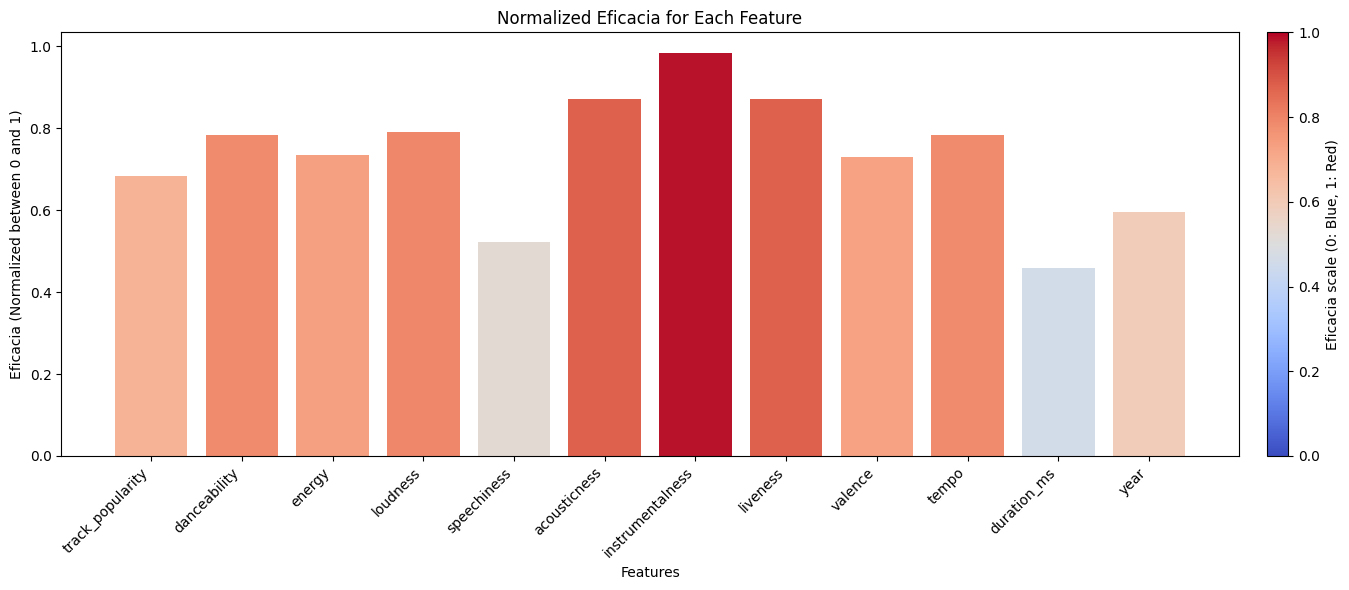

In [87]:
# Define el mapa de colores de azul (cerca de 0) a rojo (cerca de 1) para Eficacia
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])  # Setting an empty array to avoid warnings

# Crea la figura y graficar cada barra con un color basado en el valor de Eficacia
fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(comparison_df.index, comparison_df['Eficacia (%)'], color=sm.to_rgba(comparison_df['Eficacia (%)']))

# Personaliza las etiquetas del eje x
ax.set_xticks(range(len(comparison_df.index)))
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right', fontsize=10)

# Etiquetas y título
ax.set_xlabel("Features")
ax.set_ylabel("Eficacia (Normalized between 0 and 1)")
ax.set_title("Normalized Eficacia for Each Feature")

# Agrega la barra de colores con un eje específico
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Eficacia scale (0: Blue, 1: Red)')

plt.tight_layout()
plt.show()


Con este dashboard podemos observar la influencia de cada feature para la recomendación particular realizada (estos valores cambian al generar recomendaciones para otras canciones).

In [88]:
threshold = 0.6
indices = comparison_df[comparison_df['Eficacia (%)'] > threshold].index
top_features = comparison_df.loc[indices].sort_values(by="Eficacia (%)", ascending=False)
print("Eficacia de los features representativos:")
for i, (feature, row) in enumerate(top_features['Eficacia (%)'].items(), start=1):
    print(f"{i}º) {feature}: {row*100:.1f}%")
    
#print(top_features['Eficacia'])

Eficacia de los features representativos:
1º) instrumentalness: 98.5%
2º) acousticness: 87.3%
3º) liveness: 87.3%
4º) loudness: 79.2%
5º) tempo: 78.4%
6º) danceability: 78.3%
7º) energy: 73.4%
8º) valence: 73.0%
9º) track_popularity: 68.3%


**Posibles mejoras a futuro:**
- Se puede ponderar el peso de ciertas features en la búsqueda para que se les de más importancia durante la recomendación (por ejemplo el año, favoreciendo canciones actuales).
- Se puede incluir un feature que indique el idioma de la letra y/o del artista, para evitar que se realicen recomendaciones de culturas muy distantes a la del usuario.

# Predicción para canciones externas

Proceso:
1. El usuario selecciona una canción a través de la UI web,
2. Se hace una solicitud de información _SearchByName()_ para obtener el track_id
3. Se le solicitan a la API de Spotify los features a través de _GetTrackInfo()_ y _GetAudiosFeatures()_
4. Se procesan y ordenan los datos devueltos por la API
5. Se devuelve un archivo JSON con los features:

        { "track_id": "1z1Hg7Vb0AhHDiEmnDE79l",

        "track_name": "All the Time - Don Diablo Remix",

        "track_artist": "Zara Larsson",

        "track_artist_id": "1Xylc3o4UrD53lo9CvFvVg",

        "track_popularity": 42,

        "track_album_id": "1HoSmj2eLcsrR0vE9gThr4",

        "track_album_name": "All the Time (Don Diablo Remix)",

        "album_release_date": "2019-07-05",

        "year": 2019,

        "danceability": 0.675,

        "energy": 0.931,

        "key": 1,

        "loudness": -3.432,

        "mode": 0,

        "speechiness": 0.0742,

        "acousticness": 0.0794,

        "instrumentalness": 0.0000233,

        "liveness": 0.11,

        "valence": 0.613,

        "tempo": 124.008,

        "duration_ms": 176616 }


In [2]:
# Se crea X[new_song] con los features
features = {'track_id': '1z1Hg7Vb0AhHDiEmnDE79l',
 'track_name': 'All the Time - Don Diablo Remix',
 'track_artist': 'Zara Larsson',
 'track_artist_id': '1Xylc3o4UrD53lo9CvFvVg',
 'track_popularity': 42,
 'track_album_id': '1HoSmj2eLcsrR0vE9gThr4',
 'track_album_name': 'All the Time (Don Diablo Remix)',
 'album_release_date': '2019-07-05', # Debería llamarse 'track_album_release_date'
 'year': 2019,
 'danceability': 0.675,
 'energy': 0.931,
 'key': 1,
 'loudness': -3.432,
 'mode': 0,
 'speechiness': 0.0742,
 'acousticness': 0.0794,
 'instrumentalness': 2.33e-05,
 'liveness': 0.11,
 'valence': 0.613,
 'tempo': 124.008,
 'duration_ms': 176616}


In [90]:
song = pd.DataFrame([features])

In [5]:
# Input from API data
song

,track_id,track_name,track_artist,track_artist_id,track_popularity,track_album_id,track_album_name,album_release_date,year,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,1Xylc3o4UrD53lo9CvFvVg,42,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,2019,0.675,...,1,-3.432,0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616


## Feature transformation

Se eliminan las features que no son necesarias para la predicción

In [92]:
song.drop(columns=['mode', 'album_release_date', 'track_artist_id', 'album_release_date', 'key'],inplace=True)

Se realiza el proceso inverso de escalado y correción de skewness

In [93]:
# Escalado de variables
import pickle
from sklearn.preprocessing import MinMaxScaler

with open('/kaggle/input/transformations/scaler_minmax.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Transformar nuevos datos usando el scaler cargado
song_scaled[['track_popularity','loudness','tempo','duration_ms','year']] = scaler.transform(song[['track_popularity','loudness','tempo','duration_ms','year']])
song_scaled.describe()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,track_popularity,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000
mean,0.348315,0.984127,0.001857,0.318563,0.847354,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.231602
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.348315,0.984127,0.001857,0.318563,0.847354,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.231602
25%,0.348315,0.984127,0.001857,0.318563,0.847354,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.231602
50%,0.348315,0.984127,0.001857,0.318563,0.847354,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.231602
75%,0.348315,0.984127,0.001857,0.318563,0.847354,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.231602
max,0.348315,0.984127,0.001857,0.318563,0.847354,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.231602


In [19]:
# Define custom transformers
def cube(x):
    return x ** 3

def custom(x):
    return x**3

# Mapping of transformer functions to names
transformer_name_map = {
    np.log1p: 'log1p',
    np.sqrt: 'sqrt',
    np.square: 'square',
    np.exp: 'exp',
    cube: 'cube',
    custom: '<lambda>'
}

# Reverse mapping of names to functions
function_map = {v: k for k, v in transformer_name_map.items()}

In [20]:
skew_df

,feature,before,after,transformer
0,danceability,-0.509465,0.068132,square
1,energy,-0.618038,0.021180,square
2,loudness,-1.207299,0.259905,<lambda>
3,speechiness,1.957412,1.706533,log1p
4,acousticness,1.520854,1.232014,log1p
5,instrumentalness,2.750647,2.602360,log1p
6,liveness,2.097531,1.686185,log1p
7,duration_ms,1.168092,0.729589,log1p
8,year,-1.892769,1.139793,<lambda>


In [21]:
# Corrección de Skewness
skew_df = pd.read_csv('/kaggle/input/transformations/skew_correct.csv')

def apply_transformations(df, skew_df):
    for idx, row in skew_df.iterrows():
        feature = row['feature']
        transformer_name = row['transformer']
        
        if transformer_name != 'None' and feature in df.columns:
            transformer = function_map.get(transformer_name)
            if transformer is not None:
                if transformer == np.sqrt:
                    df[feature] = transformer(df[feature] + 1)
                else:
                    df[feature] = transformer(df[feature])
            else:
                print(f"Transformer '{transformer_name}' not found for feature '{feature}'.")
    return df

# Assuming 'new_df' is your new dataset
song_scaled = apply_transformations(song_scaled, skew_df)


In [54]:
# Output formatted for model
song_scaled

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,0.348315,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),0.953133,0.001857,0.318563,0.608407,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.189228


### Comparación de features escalados (verificación)

Se verifica que la distribución de valores de cada feature luego de las transformaciones tenga sentido y se encuentren dentro del rango de las features del dataset.

In [6]:
song.describe()

,track_popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,1.0,1.0,1.000,1.000,1.0,1.000,1.0,1.0000,1.0000,1.000000,1.00,1.000,1.000,1.0
mean,42.0,2019.0,0.675,0.931,1.0,-3.432,0.0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,42.0,2019.0,0.675,0.931,1.0,-3.432,0.0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616.0
25%,42.0,2019.0,0.675,0.931,1.0,-3.432,0.0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616.0
50%,42.0,2019.0,0.675,0.931,1.0,-3.432,0.0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616.0
75%,42.0,2019.0,0.675,0.931,1.0,-3.432,0.0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616.0
max,42.0,2019.0,0.675,0.931,1.0,-3.432,0.0,0.0742,0.0794,0.000023,0.11,0.613,124.008,176616.0


In [24]:
song_scaled.describe()

,track_popularity,year,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000
mean,0.348315,0.953133,0.001857,0.318563,0.608407,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.189228
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.348315,0.953133,0.001857,0.318563,0.608407,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.189228
25%,0.348315,0.953133,0.001857,0.318563,0.608407,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.189228
50%,0.348315,0.953133,0.001857,0.318563,0.608407,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.189228
75%,0.348315,0.953133,0.001857,0.318563,0.608407,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.189228
max,0.348315,0.953133,0.001857,0.318563,0.608407,0.069131,0.073627,0.000023,0.099266,0.613,0.490757,0.189228


In [7]:
df.describe()

,track_popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
count,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000,23081.000000
mean,0.411510,0.451754,0.513626,0.421495,0.098426,0.152717,0.065676,0.165481,0.509312,0.469421,0.285104,0.720546
std,0.197534,0.181832,0.236740,0.141470,0.085541,0.171373,0.167241,0.115768,0.232680,0.173978,0.094592,0.291073
min,0.000000,0.005944,0.000139,0.000000,0.022153,0.000001,0.000000,0.009316,0.000010,0.000000,0.000000,0.000000
25%,0.269663,0.318096,0.328329,0.329304,0.040086,0.015972,0.000000,0.088652,0.329000,0.334020,0.224866,0.562326
50%,0.415730,0.452929,0.512656,0.431469,0.060530,0.082317,0.000016,0.118672,0.510000,0.477115,0.274422,0.863838
75%,0.561798,0.580644,0.698896,0.522671,0.124869,0.240590,0.004798,0.217528,0.691000,0.558260,0.335173,0.953133
max,1.000000,0.966289,1.000000,1.000000,0.651283,0.689139,0.690143,0.691145,0.991000,1.000000,0.693147,1.000000


## Creación de vector embedding

In [27]:
X_song = song_scaled[features].values.astype('float32')

Se realiza una predicción con estas nuevas features para localizar la canción externa dentro del espacio latente del modelo de embeddings

In [28]:
# Para nuevas caciones exsternas al dataset
new_song_embedding = embedding_model.predict(X_song)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


## Generación de recomendaciones

Se buscan por similitud de coseno los 5 vectores más cercanos al nuevo vector generado.

In [55]:
num_pred = 5 # Modificar a gusto para obtener más predicciones
similarities = cosine_similarity(new_song_embedding, song_embeddings)[0]

# Get top n most similar songs (excluding itself)
similar_indices = np.argsort(similarities)[-(num_pred+1):-1][::-1]
similar_songs = df.iloc[similar_indices]

for i, song in enumerate(similar_songs.index):
    print(f"{i+1}º) \"{similar_songs.loc[song, 'track_name']}\" by {similar_songs.loc[song, 'track_artist']} on album \"{similar_songs.loc[song, 'track_album_name']}\"\n")

1º) "Know" by Syd on album "Fin"

2º) "Waste My Youth" by GALXARA on album "Waste My Youth"

3º) "Lookin' At You" by RudeLies on album "Lookin' At You"

4º) "Almost Love" by Ashlie Amber on album "Almost Love"

5º) "Yeah Yeah" by MELANIE? on album "Yeah Yeah"



In [56]:
similar_songs

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
19070,4xyoLXrUb0cpROQwZe1ggb,Know,Syd,0.370787,59Bbr32pMTFHlUb8Nv1Kr0,Fin,r&b,0.246016,0.422500,0.578524,0.098034,0.226338,0.000009,0.096219,0.551,0.561754,0.275650,0.863838
1778,4ccKliPoo6GU5qCVbss4rt,Waste My Youth,GALXARA,0.303371,6Ehkpd03CT98UVJHan7c9o,Waste My Youth,pop,0.168921,0.501264,0.642484,0.102557,0.099845,0.000000,0.302324,0.604,0.600778,0.273812,0.953133
12891,6dji95wvWJgIxi0f3io7mz,Lookin' At You,RudeLies,0.348315,4wq4r86F5OW1sYLfnPdkTr,Lookin' At You,latin,0.219024,0.491401,0.545922,0.047742,0.068219,0.000394,0.106160,0.801,0.497256,0.174439,0.953133
10228,4QpQD2qeHHwzEKZ1rCJLcv,Almost Love,Ashlie Amber,0.224719,6vEzO4gmCxfSkqlgBTvTfU,Almost Love,rock,0.170569,0.375769,0.429971,0.029267,0.126633,0.000000,0.251537,0.408,0.802517,0.255695,0.953133
10177,2mYYk3wqFEERVj93fW05iM,Yeah Yeah,MELANIE?,0.247191,4asSq2UZIYwyiuvctsj8Rq,Yeah Yeah,rock,0.175561,0.481636,0.527166,0.032661,0.014199,0.000585,0.217528,0.362,0.895715,0.210754,0.953133


## Validación de resultados

Se calculan métricas RMSE para medir la diferencia para cada feature entre la canción original, las recomendaciones y el resto del dataset.

In [63]:
# 0. Canción original (user input)
song = song_scaled.copy().squeeze()
song = song.drop(index=['track_id','track_name','track_artist',
                       'track_album_id','track_album_name'])
song = song.astype(float)

# 0. Calcular la media de las características en el dataframe completo
df_mean = df[features].mean()

# 1. Filtrar las canciones similares usando los índices y calcular la media
similar_mean = similar_songs[features].mean()

# 2. Crear un DataFrame que contenga ambas medias para fácil comparación
comparison_df = pd.DataFrame({'Original song': song, 'Similar songs': similar_mean})

# 3. Calcular el RMSE entre la canción original y la media de las canciones similares
comparison_df['Similarity (RMSE)'] = np.sqrt((comparison_df['Original song'] - comparison_df['Similar songs']) ** 2)
comparison_df['Other songs'] = df_mean

# 4. Calcular el RMSE entre la media de canciones similares y la media general
comparison_df['Difference (RMSE)'] = np.sqrt((comparison_df['Similar songs'] - comparison_df['Other songs']) ** 2)

# 5. Compara el RMSE de la predicción contra la media del dataset (Normalizado)
comparison_df['Eficacia (%)'] =  comparison_df['Difference (RMSE)'] / (comparison_df['Similarity (RMSE)'] + comparison_df['Difference (RMSE)'])
# Valores cercanos a 1 indican una predicción excelente
# Valores cercanos a 0 indican una predicción pobre (RMSE similar entre la predicción y la media)

In [74]:
comparison_df

,Original song,Similar songs,Similarity (RMSE),Other songs,Difference (RMSE),Eficacia (%)
acousticness,0.073627,0.107047,0.033420,0.152717,0.045671,0.577448
danceability,0.001857,0.196018,0.194161,0.451754,0.255736,0.568432
duration_ms,0.189228,0.238070,0.048842,0.285104,0.047034,0.490569
energy,0.318563,0.454514,0.135951,0.513626,0.059112,0.303040
instrumentalness,0.000023,0.000197,0.000174,0.065676,0.065478,0.997347
liveness,0.099266,0.194754,0.095488,0.165481,0.029273,0.234634
loudness,0.608407,0.544813,0.063594,0.421495,0.123318,0.659766
speechiness,0.069131,0.062052,0.007079,0.098426,0.036373,0.837095
tempo,0.490757,0.671604,0.180847,0.469421,0.202183,0.527852
track_popularity,0.348315,0.298876,0.049438,0.411510,0.112634,0.694962


**NOTAS:**
- Similarity/Diference: representan la proximidad de los datos a través del RMSE (0 es "similar" | 1 es "diferente")
- Eficacia: 1 indica una predicción excelente. 0 indica una predicción pobre.

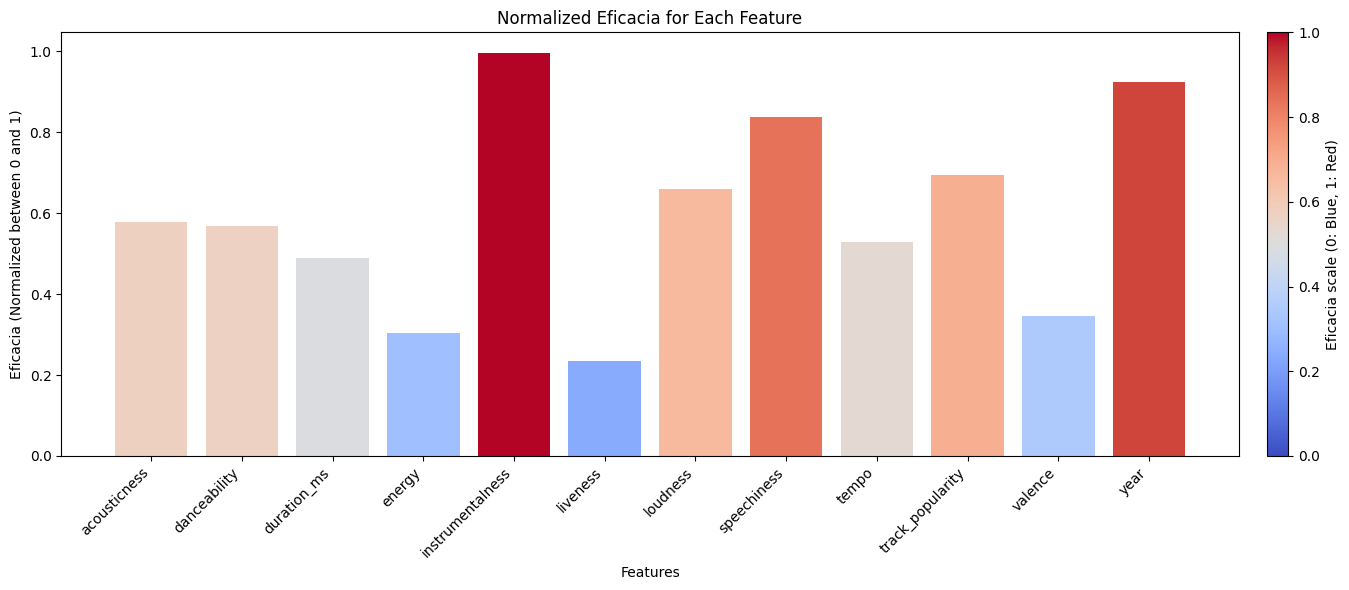

In [81]:
# Define the color map from blue (near 0) to red (near 1) for Eficacia

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])  # Setting an empty array to avoid warnings

# Create the figure and plot each bar with color based on Eficacia value
fig, ax = plt.subplots(figsize=(15, 6))

bars = ax.bar(
    comparison_df.index, 
    comparison_df['Eficacia (%)'], 
    color=sm.to_rgba(comparison_df['Eficacia (%)'])
)

# Personalizar las etiquetas del eje x
ax.set_xticks(range(len(comparison_df.index)))
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right', fontsize=10)

# Etiquetas de los ejes y título
ax.set_xlabel("Features")
ax.set_ylabel("Eficacia (Normalized between 0 and 1)")
ax.set_title("Normalized Eficacia for Each Feature")

# Añadir una barra de colores
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Eficacia scale (0: Blue, 1: Red)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [82]:
threshold = 0.6
indices = comparison_df[comparison_df['Eficacia (%)'] > threshold].index
top_features = comparison_df.loc[indices].sort_values(by="Eficacia (%)", ascending=False)
print("Eficacia de los features representativos:")
for i, (feature, row) in enumerate(top_features['Eficacia (%)'].items(), start=1):
    print(f"{i}º) {feature}: {row*100:.1f}%")
    
#print(top_features['Eficacia'])

Eficacia de los features representativos:
1º) instrumentalness: 99.7%
2º) year: 92.3%
3º) speechiness: 83.7%
4º) track_popularity: 69.5%
5º) loudness: 66.0%


# ⚠️ DISCLAIMER IMPORTANTE

Lamentablemente, el día **27 de Noviembre de 2024** Spotify tomó la decisión de **deprecar sin previo aviso varios endpoints de la API**, particularmente las relacionadas con "Audio Features" que estábamos utilizando para poder hacer búsquedas de similitud con cualquier input de usuario.

_**Anuncio de cambios:** https://developer.spotify.com/blog/2024-11-27-changes-to-the-web-api_

Esta funcionalidad nos permitía:
1. Extraer "audio features" de la canción de preferencia del usuario y utilizar esos valores para realizar la búsqueda de similitud dentro de nuestro dataset.

2. Hacer re-entrenamiento en batch del dataset para que pudiera ser actualizado regularmente.

_**Endpoint deprecado:** https://developer.spotify.com/documentation/web-api/reference/get-audio-features_